# MyCiTi Bus Services in Cape Town

#### Capstone Project for Applied Data Science by IBM/Coursera

## Background & Problem

Cape Town, one of the most beautiful cities in the world, also happens to be one of the most congested when it comes to road traffic. <span style='color:green'>[1]</span>

According to the INRIX 2018 Global Traffic Scorecard, people in Cape Town lose 162 hours per year to congestion. <span style='color:green'>[2]</span>

In recent years this issue has become even more acute due to a rapid population increase and a lack of investment into rail infrastructure.

Given that 80% of daily congestion in Cape Town consists of private vehicles <span style='color:green'>[1]</span>, one solution would be to improve the shared public transport, which is currently represented by:
 - Metrorail, a rail service that nowadays is considered by many too dilapidated and unsafe
 - Minibus taxis, informally operated network of shared minibuses, with no set map or timetable <span style='color:green'>[3]</span>
 - Golden Arrow, a privately-owned point-to-point bus service operating at morning and evening peak hours; the City of Cape Town is not able to control the extent and quality of this service
 - MyCiTi, a bus rapid transit system provided by the City of Cape Town, operating on a regular time table throughout the day using dedicated road infrastructure and technology

While the need of investment into rail infrastructure is widely recognised, it appears that the City of Cape Town sees MyCiTi as the most viable response to public transportation needs. The MyCiTi network was launched in May 2010 and is still growing.

In this analysis we would like to focus on the MyCiTi network, first mapping and visualising its current extent and then suggesting ways for future growth, taking into account the following two facts <span style='color:green'>[4]</span>:
1. 95% of public transport users are in the low to low-middle income brackets
2. 95% of people in high-income communities own a car

So the real question that we are aiming to answer is: how should we expand the MyCiTi network so that we encourage private car users to switch over to public buses, and what areas currently served by Minibus taxis and Golden Arrow buses would benefit from MyCiTi?

We are confident that the Transport and Urban Development Authority of Cape Town has a team of data scientists, its own private data sources and a strategy for development, but we will still undertake this exercise from an outsider's perspective, using publicly available data.
This analysis may be of interest to those working at the Transport and Urban Development Authority of Cape Town, or those with a general interest in public transport.


## Data

From the administrative perspective the City of Cape Town is split into more than 700 communities called suburbs.

To understand the existing transportation needs we would need to determine the locations of MyCiTi bus stops and also estimate how wealthy each of the suburbs is and how many residents it has.

To estimate suburb wealth we will use the breakdown of suburb properties by value, as provided by the City of Cape Town Open Data Portal <span style='color:green'>[5]</span>.

We could not find the population statistics per suburb (latest census data is from 2011 and is not split by suburb), hence we are planning to use the total number of properties in a suburb as an approximation.

Therefore we will need the following datasets for our analysis:
1. Coordinates of Cape Town suburbs, to be obtained from Open Data Portal <span style='color:green'>[5]</span>
2. Number of properties by suburb and value band, to be obtained from Open Data Portal <span style='color:green'>[5]</span>
3. Coordinates of MyCiTi bus stops, to be obtained from Foursquare

## Methodology

For our analysis we are planning to use the following approach to source and pre-process our data:
1. First, we will visualise the map of Cape Town's suburbs to better understand the geography we are dealing with.
2. Then we will obtain, cleanse and visualise the geographical locations of all MyCiTi bus stops using the Foursquare service.
3. Finally, we will obtain and cleanse the property valuations from the Open Data Portal of Cape Town.

Once we have a clean dataset, we will hopefully be able to run K-means clustering to classify Cape Town's suburbs by wealth, see which of them are more populous than others, and understand the current coverage of the MyCiTi service.

### Suburbs (Open Data Portal)

To begin with, let's determine the geographical coordinates of Cape Town:

In [2]:
!pip install geopy
from geopy.geocoders import Nominatim

     |████████████████████████████████| 112kB 5.8MB/s eta 0:00:01


In [3]:
address = 'Cape Town, South Africa'
geolocator = Nominatim(user_agent="coursera_capstone_test")
location = geolocator.geocode(address)
lat_ct = location.latitude
lon_ct = location.longitude
print('The geographical coordinates of ' + address + ' are {}, {}.'.format(lat_ct, lon_ct))

The geographical coordinates of Cape Town, South Africa are -33.928992, 18.417396.


Now let's download the list and boundaries of all the suburbs of Cape Town from the Open Data Portal:

In [4]:
!wget --quiet https://opendata.arcgis.com/datasets/8ebcd15badfe40a4ab759682aacf8439_75.geojson -O Official_Suburbs.geojson

In [5]:
import json

In [6]:
with open('Official_Suburbs.geojson', 'r') as geo_file_suburbs:
    geo_data_suburbs = json.load(geo_file_suburbs)

Let's parse the GeoJSON file, recording the suburb ID, suburb name and the boundaries. We will also calculate the centroid for each suburb.  
It is worth noting that some suburbs are represented as several non-overlapping polygons, and some have 'holes'.

In [7]:
!pip install shapely
from shapely.geometry import shape
import numpy as np

     |████████████████████████████████| 1.8MB 19.2MB/s eta 0:00:01


In [8]:
suburbs = []
for f in geo_data_suburbs['features']:
    if f['geometry']['type'] == 'MultiPolygon':
        shapes = [s for s in shape(f['geometry'])]
        centroids = [[s.centroid.y, s.centroid.x] for s in shape(f['geometry'])]
    else:
        shapes = [shape(f['geometry'])]
        centroids = [[shape(f['geometry']).centroid.y, shape(f['geometry']).centroid.x]]
    suburbs.append([f['properties']['OBJECTID'], f['properties']['OFC_SBRB_NAME'], centroids, shapes])

Let's now display the suburbs map, highlighting the centroid point of each suburb in red, and the centre of Cape Town (as returned by Nominatim) in orange.

In [9]:
import folium

In [10]:
m = folium.Map(location=[lat_ct, lon_ct], zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(m)
folium.GeoJson('Official_Suburbs.geojson', name='geojson').add_to(m)
for s in suburbs:
    for c in s[2]:
         folium.Circle(c, radius=5, fill=True, fill_opacity=1, color='red').add_to(m)
folium.Circle([lat_ct, lon_ct], radius=500, fill=True, fill_opacity=1, color='orange').add_to(m)
m.save('Map 1 - Official Suburbs.html')

### MyCiTi Bus Stops (Foursquare)

Now that we better understand what geography we are dealing with, let's fetch the MyCiTi bus stop locations from Foursquare.

It would have been easy to run one single Foursquare query, placing the centre of the search in the geographical point determined by Nominatim and supplying a sufficiently big radius to cover all of Cape Town. Our practical experiment shows, however, that such an approach returns only a fraction of the data available in Foursquare, as there is a limit as to how many venues can be returned by a single query (only up to 50 venues returned). We will therefore have to employ a different approach:
1. Determine the minimum and maximum geographical coordinates of Cape Town's suburbs in order to determine the city's diameter.
2. Re-position the city centre accordingly.
3. Divide the resulting circle into smaller areas that can be searched by Foursquare without a data loss.

Let's scan the suburbs to determine the most southwestern and northeastern points:

In [11]:
lat_min, lat_max, lon_min, lon_max = lat_ct, lat_ct, lon_ct, lon_ct
for suburb in suburbs:
    for poly in suburb[3]:
        for coords in poly.exterior.coords:
            if coords[1] > lat_max:
                lat_max = coords[1]
            if coords[1] < lat_min:
                lat_min = coords[1]
            if coords[0] > lon_max:
                lon_max = coords[0]
            if coords[0] < lon_min:
                lon_min = coords[0]
print('Min coords:', lat_min, lon_min)
print('Max coords:', lat_max, lon_max)

Min coords: -34.35904391636636 18.307449125750356
Max coords: -33.471273996519386 19.004667336304436


The distance between the two points is the diameter defining our Foursquare search, so let's define a function and calculate the distance:

In [12]:
import math

In [13]:
# returns the distance between two coordinates, in metres
def distance(lat1, lon1, lat2, lon2):
    p = math.pi / 180
    a = 0.5 - math.cos((lat2 - lat1) * p)/2 + math.cos(lat1 * p) * math.cos(lat2 * p) * (1 - math.cos((lon2 - lon1) * p)) / 2
    return 2 * 6371000 * math.asin(math.sqrt(a)) # 2 * R of Earth in metres * asin

In [14]:
d = distance(lat_min, lon_min, lat_max, lon_max)
print('Distance between the min and max points in metres: {}'.format(d))

Distance between the min and max points in metres: 117829.51250752936


At 118 kilometres in diameter, Cape Town is a big city\!  
This will be our new city centre for the Foursquare search:

In [15]:
lat_centre = lat_min + (lat_max - lat_min) / 2
lon_centre = lon_min + (lon_max - lon_min) / 2
print('The new geographical coordinates of ' + address + ' are {}, {}.'.format(lat_centre, lon_centre))

The new geographical coordinates of Cape Town, South Africa are -33.91515895644287, 18.656058231027394.


Let's now define the functions to convert geographical coordinates into the UTM system (and back), and methodically break down the whole of Cape Town into smaller search zones to be used for the Foursquare search. In order to do that, we will create a honeycomb-like pattern of circles, so we need to define the coordinates of the centre of each of the honeycomb cells. Initially we set the diameter of each cell to be one-tenth of the diameter of Cape Town, however later we had to decrease the size to 1/30th due to Foursquare limitations.

In [16]:
import pyproj

In [17]:
def distance_utm(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

In [18]:
def latlon_2_utm(lat, lon):
    proj_latlong = pyproj.Proj(proj='latlong', datum='WGS84')
    proj_utm = pyproj.Proj(proj='utm', zone=34, datum='WGS84')  # Cape Town is in UTM zone 34
    utm = pyproj.transform(proj_latlong, proj_utm, lon, lat)
    return utm[0], utm[1]

In [19]:
def utm_2_latlon(x, y):
    proj_latlong = pyproj.Proj(proj='latlong', datum='WGS84')
    proj_utm = pyproj.Proj(proj='utm', zone=34, datum='WGS84')  # Cape Town is in UTM zone 34
    lonlat = pyproj.transform(proj_utm, proj_latlong, x, y)
    return lonlat[1], lonlat[0]

In [20]:
x_centre, y_centre = latlon_2_utm(lat_centre, lon_centre)
k = math.sqrt(3) / 2
m = 30
dx = d/m
dy = k * dx
coords = []
for i in range(round(d/dy) + 1):
    y = y_centre - d/2 + i * dy
    x_offset = 0
    if i % 2 == 0:
        x_offset = dx / 2
    for j in range(m + 1):
        x = x_centre - d/2 + j * dx + x_offset
        h = distance_utm(x_centre, y_centre, x, y)
        if (h <= d/2 + dx/2):
            coords.append(utm_2_latlon(x, y))

Let's now visualise our search zones.  
The re-positioned city centre as well as the new city boundaries are shown in magenta. Orange still indicates the original centre of Cape Town, as returned by Nominatim.

In [21]:
m = folium.Map(location=[lat_centre, lon_centre], zoom_start=9)
folium.TileLayer('cartodbpositron').add_to(m)
folium.Circle([lat_centre, lon_centre], radius=d/2, fill=False, color='magenta').add_to(m)
for c in coords:
    folium.Circle([c[0], c[1]], radius=2270, color='green', fill=False).add_to(m)
folium.Circle([lat_ct, lon_ct], radius=500, fill=True, fill_opacity=1, color='orange').add_to(m)
folium.Circle([lat_centre, lon_centre], radius=500, fill=True, fill_opacity=1, color='magenta').add_to(m)
m.save('Map 2 - Foursquare Search Zones.html')

Note that while the distance between the search zone centres is 1/30th of the city diameter (i.e. approximately 4 kilometres), we have increased the diameter of search zones to 4.5 kilometres to ensure there is some overlap so that we do not miss a single bus stop in our search.

We could have also eliminated those search zones that are entirely located in the ocean, as we do not expect to find any bus stops there. But we have not.

Now, how does one fetch bus stops from Foursquare?

Foursquare classifies its venues by category, and there is a service that returns the complete tree structure of the categories. We will attempt to pull the entire category tree, and then see which categories contain the word 'bus'.

In [22]:
import requests
import pandas as pd

In [23]:
CLIENT_ID = ''  # use your ID
CLIENT_SECRET = ''  # use your secret
VERSION = '20180605'

In [24]:
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION)

In [25]:
results = requests.get(url).json()

In [26]:
def fetch_categories(categories, list_categories, level=0):
    for i in categories:
        list_categories.append([level, i['name'], i['id']])
        if i['categories'] is not None:
            fetch_categories(i['categories'], list_categories, level + 1)
    return

In [27]:
list_categories = []
fetch_categories(results['response']['categories'],  list_categories)
df_categories = pd.DataFrame(list_categories, columns=['level', 'name', 'id'])
df_categories.head()

,level,name,id
0,0,Arts & Entertainment,4d4b7104d754a06370d81259
1,1,Amphitheater,56aa371be4b08b9a8d5734db
2,1,Aquarium,4fceea171983d5d06c3e9823
3,1,Arcade,4bf58dd8d48988d1e1931735
4,1,Art Gallery,4bf58dd8d48988d1e2931735


In [28]:
df_categories.to_csv('df_all_foursquare_categories.csv', index=False)

In [29]:
df_categories[df_categories['name'].str.contains('bus', case=False)]

,level,name,id
605,1,Business Center,56aa371be4b08b9a8d573517
733,1,Business Service,5453de49498eade8af355881
902,1,Bus Station,4bf58dd8d48988d1fe931735
903,2,Bus Line,4bf58dd8d48988d12b951735
904,1,Bus Stop,52f2ab2ebcbc57f1066b8b4f


We are not interested in Business Centres or Business Services, however it is not clear which of the 3 bus categories we should use, therefore we will pull all 3 of them.
 - Bus Station (4bf58dd8d48988d1fe931735)  
 - Bus Line (4bf58dd8d48988d12b951735)  
 - Bus Stop (52f2ab2ebcbc57f1066b8b4f)

In [30]:
intent = 'browse'
radius = 2270
categories = '4bf58dd8d48988d1fe931735,4bf58dd8d48988d12b951735,52f2ab2ebcbc57f1066b8b4f'
limit = 200  # seems like the maximum returned is 50

In [31]:
fs_bus_stops = {}

In [32]:
for c in coords:
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&intent={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, intent, c[0], c[1], radius, categories, limit)
    results = requests.get(url).json()
    if len(results['response']['venues']) >= 50:
        print('Please decrease the honeycomb cell size!')
    for venue in results['response']['venues']:
        bus_stop = (venue['id'], venue['name'], venue['location']['lat'], venue['location']['lng'], venue['categories'][0]['name'])
        fs_bus_stops[venue['id']] = bus_stop

In [33]:
len(fs_bus_stops)

165

We would expect more than 165 bus stops for a system as developed as MyCiTi, but let's have a closer look at the Foursquare data\!

In [34]:
df_fs_bus_stops = pd.DataFrame(fs_bus_stops.values(), columns=['id', 'name', 'lat', 'lon', 'category'])

In [35]:
df_fs_bus_stops.head(10)

,id,name,lat,lon,category
0,4c790427dbaa76b00d57184b,Fish Hoek Taxi Rank / Bus Station,-34.136455,18.432575,Bus Station
1,54db79f3498eabafa6833aa5,Partybus SA,-34.156093,18.971288,Bus Station
2,4efc7e4ff790d5546e0bfb8a,Bushalte 'Koekamerstraat' (Lijn 61),-34.083333,18.666667,Bus Station
3,4e81539230f86985e3fec358,Bus Stop - Somerset To CPT,-34.077321,18.846245,Bus Station
4,530a462a498ea6e7b517d548,MyCiti Bus - Northsjore,-34.046962,18.348096,Bus Station
5,52dbe93e498e55ce1197c172,Kronendal Park & Ride,-34.040592,18.359938,Bus Line
6,53f6e495498ea6a295aca2d4,MyCiti Bus - Atlantic Skipper (108),-34.053463,18.349653,Bus Stop
7,57681f91cd101651d2aa9a4a,Salfred's Coach And Minibus Tours,-34.060235,18.480399,Bus Station
8,4f799c45e4b0795c39f0e592,Mitchell's plain town center( bus stop),-34.042322,18.622367,Bus Station
9,5050051ae4b020e9adb7bac0,Golden Arrow Town Centre,-34.033809,18.612445,Bus Station


As we can see, this is quite a mixed dataset. Looking at the data, we do not understand the difference between 'Bus Station', 'Bus Stop' and 'Bus Line'.  
A quick visualisation shows that there are more bus stations in Cape Town than bus stops, which does not make sense:

In [36]:
import seaborn as sns

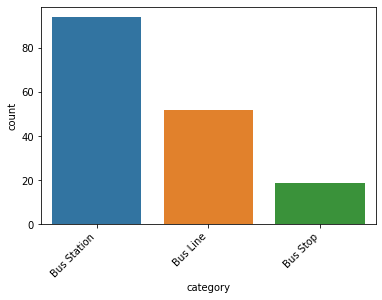

In [37]:
chart = sns.countplot(x="category", data=df_fs_bus_stops)
sns.set(rc={'figure.figsize':(4,4)})
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart

We also note that the dataset contains other items that we are not interested in, such as Partybus, Park & Ride, Coach Tours and Golden Arrow bus stops, which we need to discard.  
Given that there is no consistency in how Foursquare spells 'MyCiTi', we will keep those items that contain both 'MY' and 'CIT', case-insensitive.

In [38]:
df_fs_bus_stops = df_fs_bus_stops[df_fs_bus_stops['name'].str.contains('MY', case=False) & df_fs_bus_stops['name'].str.contains('CIT', case=False)]

In [39]:
df_fs_bus_stops.head(10)

,id,name,lat,lon,category
4,530a462a498ea6e7b517d548,MyCiti Bus - Northsjore,-34.046962,18.348096,Bus Station
6,53f6e495498ea6a295aca2d4,MyCiti Bus - Atlantic Skipper (108),-34.053463,18.349653,Bus Stop
20,4d3dd3c6af8ca143db7b0ff7,MyCity Bus Station,-33.967895,18.579911,Bus Station
23,56588b94498ebf764cdb8e61,MyCiti 110 Table Mountain,-33.944926,18.399593,Bus Line
24,52bd6b19498e30da1ca5fee5,Fiskaal Myciti bus stop,-33.958630,18.382826,Bus Station
25,59c60ebd6f0aa23f3525d8bb,Mycity: Bus Station Bakoven,-33.962778,18.373825,Bus Stop
26,52c01cd4498e2370dc36b4ab,MyCiti bus - Camps Bay,-33.951315,18.378222,Bus Station
28,56588e14498eeecedd1441e5,MyCiti Upper Tafelberg,-33.943533,18.396418,Bus Station
29,56588f19498e5e36df173566,MyCiti Lower Tafelberg,-33.942599,18.395020,Bus Station
30,50a5f41de4b0db20bfd5ce96,Myciti Bus Station Gardens,-33.934046,18.419342,Bus Station


In [40]:
len(df_fs_bus_stops)

83

In [41]:
df_fs_bus_stops.to_csv('df_all_foursquare_bus_stops.csv', index=False)

Let's visualise the 83 bus stops found:

In [42]:
m = folium.Map(location=[lat_centre, lon_centre], zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(m)
folium.GeoJson('Official_Suburbs.geojson', name='geojson').add_to(m)
for i, b in df_fs_bus_stops.iterrows():
    folium.Circle([b['lat'], b['lon']], radius=5, fill=False, color='red').add_to(m)
m.save('Map 3 - Foursquare Bus Stops.html')

Our observations:
 - Foursquare did not return any MyCiTi bus stops in Khayelitsha and Mitchells Plain, even though services have been operating there for more than 5 years.
 - The overall density of bus stops is far from what we see on the official bus map, indicating that the Foursquare dataset is far from complete. <span style='color:green'>[6]</span>
 - Despite our hopes, one of the Foursquare bus stops is located in the Atlantic Ocean.

This makes us wonder if there is an alternative data provider that we could use?  
We have found a similar dataset on the Open Data Portal <span style='color:green'>[5]</span>, however it contains specifically MyCiTi stops only, so let's look at it to see if it is any better.

### MyCiTi Bus Stops (Open Data Portal)

In [43]:
!wget --quiet https://opendata.arcgis.com/datasets/19684ea3f08b4c95ab4fe7099ed75e81_96.geojson -O Bus_Stops.geojson

In [44]:
with open('Bus_Stops.geojson', 'r') as geo_file_bus_stops:
    geo_data_bus_stops = json.load(geo_file_bus_stops)

In [45]:
bus_stops = []
for f in geo_data_bus_stops['features']:
    bus_stops.append([f['properties']['NAME'].strip(), f['geometry']['coordinates'][1], f['geometry']['coordinates'][0]])

In [46]:
df_bus_stops = pd.DataFrame(bus_stops, columns=['name', 'lat', 'lon'])
df_bus_stops.shape

(1810, 3)

In [47]:
df_bus_stops.head()

,name,lat,lon
0,Atlantis,-33.563905,18.491651
1,Arion,-33.559079,18.496201
2,Charel Uys North,-33.555698,18.493862
3,Montreal,-33.552135,18.493488
4,Tsitsikamma,-33.547498,18.494424


As we can see, there are substantially more bus stops than the 83 returned by Foursquare, however some data cleansing is still required.  
For example, it looks like the dataset has two separate entries for the two opposite directions of the same bus stop.  
We also note there are entries with blank names (what are they?), and one bus stop is misspelled (10 Avenue).

In [48]:
df_bus_stops.replace('10 Avenue', '10th Avenue', inplace=True)
df_bus_stops.drop_duplicates(inplace=True)
df_bus_stops.shape

(966, 3)

In [49]:
df_bus_stops_empty = df_bus_stops.loc[df_bus_stops['name'] == '']
df_bus_stops_valid = df_bus_stops.loc[df_bus_stops['name'] != '']
len(df_bus_stops_empty)

18

For the 18 bus stops with empty names let's check if there is another bus stop with a valid name and exactly the same coordinates:

In [50]:
df_bus_stops_empty_enriched = pd.merge(df_bus_stops_empty, df_bus_stops_valid, on=['lat', 'lon'])
df_bus_stops_empty_enriched

,name_x,lat,lon,name_y
0,,-33.927658,18.464364,Salt River Rail
1,,-33.929330,18.464814,Spencer
2,,-33.928923,18.458854,Kent
3,,-33.930004,18.457270,Upper Salt River
4,,-33.931833,18.452922,Lawley
5,,-33.934748,18.451638,Balfour
6,,-33.937594,18.451061,Upper Roodebloem
7,,-33.936044,18.448998,Upper Mountain
8,,-33.934834,18.446958,Coronation East
9,,-33.934494,18.443189,Coronation West


As we can see, each and every one of them actually has also been defined with a valid name. We will therefore simply drop the bus stops with empty names.

In [51]:
df_bus_stops = df_bus_stops_valid.sort_values(by=['name', 'lat', 'lon'])
df_bus_stops.reset_index(drop=True, inplace=True)
df_bus_stops.head()

,name,lat,lon
0,10th Avenue,-34.041992,18.617469
1,10th Avenue,-34.041992,18.617468
2,6th Avenue,-34.052644,18.625384
3,6th Avenue,-34.052592,18.625469
4,Abalone,-33.831848,18.546718


There are still what we consider duplicates for the sake of our exercise, i.e. bus stops having the same name located too close to each other.  
How can we exclude such duplicates? In a group of bus stops having the same name, let's calculate the distance to the next bus stop in this sorted list.

In [52]:
df_bus_stops['distance'] = -1.0
for i in range(len(df_bus_stops)-1):
    if df_bus_stops['name'][i] == df_bus_stops['name'][i+1]:
        d = distance(df_bus_stops['lat'][i], df_bus_stops['lon'][i], df_bus_stops['lat'][i+1], df_bus_stops['lon'][i+1])
        df_bus_stops.iloc[i+1, 3] = d

In [53]:
df_bus_stops.head()

,name,lat,lon,distance
0,10th Avenue,-34.041992,18.617469,-1.000000
1,10th Avenue,-34.041992,18.617468,0.078666
2,6th Avenue,-34.052644,18.625384,-1.000000
3,6th Avenue,-34.052592,18.625469,9.734506
4,Abalone,-33.831848,18.546718,-1.000000


Now let's check if there are any suspicious cases, e.g. bus stops having the same name but located very far apart from each other:

In [54]:
df_bus_stops[df_bus_stops['distance'] > 200].sort_values('distance', ascending=False)

,name,lat,lon,distance
336,Goede Hoop,-33.550905,18.484894,34606.735800
413,Irwinton,-33.918578,18.390877,228.798102
654,Patrys,-33.570966,18.503298,219.279092
230,Darling,-33.922465,18.423899,216.344033
925,Whale Rock,-33.953279,18.377075,211.438163


Indeed our results indicate that there are two groups of bus stops called 'Goede Hoop' located in very different parts of the city. Let's rename one of the groups:

In [55]:
df_bus_stops[df_bus_stops['name'] == 'Goede Hoop']

,name,lat,lon,distance
334,Goede Hoop,-33.859518,18.534821,-1.000000
335,Goede Hoop,-33.859356,18.534740,19.504496
336,Goede Hoop,-33.550905,18.484894,34606.735800
337,Goede Hoop,-33.550886,18.484836,5.774952
338,Goede Hoop,-33.550884,18.484831,0.507834


In [56]:
df_bus_stops.iloc[334, 0] = 'Goede Hoop Bothasig'
df_bus_stops.iloc[335, 0] = 'Goede Hoop Bothasig'
df_bus_stops.iloc[336, 3] = -1

Now we can drop the bus stops located too close to each other and forming a cluster, so that only one of them remains:

In [57]:
indices_to_drop = df_bus_stops[df_bus_stops['distance'] != -1].index
df_bus_stops.drop(indices_to_drop, inplace=True)
df_bus_stops.drop('distance', axis=1, inplace=True)
df_bus_stops.reset_index(drop=True, inplace=True)
df_bus_stops.shape

(518, 3)

In [58]:
df_bus_stops.head()

,name,lat,lon
0,10th Avenue,-34.041992,18.617469
1,6th Avenue,-34.052644,18.625384
2,Abalone,-33.831848,18.546718
3,Acacia,-33.579636,18.502975
4,Adderley,-33.920845,18.424676


In [59]:
df_bus_stops.to_csv('df_all_opendata_bus_stops.csv', index=False)

This is a much better result.  
Let's now determine which suburb each of the bus stops belongs to, we might need this metric later on in our analysis.

In [60]:
from shapely.geometry import Point

In [61]:
df_bus_stops['suburb'] = None

In [62]:
df_bus_stops.head()

,name,lat,lon,suburb
0,10th Avenue,-34.041992,18.617469,None
1,6th Avenue,-34.052644,18.625384,None
2,Abalone,-33.831848,18.546718,None
3,Acacia,-33.579636,18.502975,None
4,Adderley,-33.920845,18.424676,None


In [63]:
for suburb in suburbs:
    for p in suburb[3]:
        for b in range(len(df_bus_stops)):
            if p.contains(Point(df_bus_stops.loc[b, 'lon'], df_bus_stops.loc[b, 'lat'])):
                if df_bus_stops.iloc[b, 3] is None:
                    df_bus_stops.iloc[b, 3] = suburb[1]
                else:
                    df_bus_stops.iloc[b, 3] = df_bus_stops.iloc[b, 3] + ', ' + suburb[1]

In [64]:
df_bus_stops.head()

,name,lat,lon,suburb
0,10th Avenue,-34.041992,18.617469,MITCHELLS PLAIN CBD
1,6th Avenue,-34.052644,18.625384,EASTRIDGE
2,Abalone,-33.831848,18.546718,RICHWOOD
3,Acacia,-33.579636,18.502975,PROTEA PARK - WESFLEUR
4,Adderley,-33.920845,18.424676,FORESHORE


Let's check if there are bus stops that have not been assigned to a suburb, or that have been assigned to more than one suburb:

In [65]:
df_bus_stops[(df_bus_stops['suburb'].isnull()) | (df_bus_stops['suburb'].str.contains(','))]

,name,lat,lon,suburb
364,Perlemoen,-33.807416,18.466714,None


A closer look at the map reveals that the Perlemoen bus stop belongs to BLAAUWBERGSTRAND, however suburb boundaries defined bin the Open Data Portal are not perfect.

In [66]:
df_bus_stops.iloc[364, 3] = 'BLAAUWBERGSTRAND'

Let's visualise our dataset:

In [67]:
m = folium.Map(location=[lat_ct, lon_ct], zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(m)
folium.GeoJson('Official_Suburbs.geojson', name='geojson').add_to(m)
for i, b in df_bus_stops.iterrows():
    folium.Circle([b['lat'], b['lon']], radius=5, fill=False, color='red').add_to(m)
m.save('Map 4 - Open Data Portal Bus Stops.html')

This is a much better result, so we will stick with this dataset.  
We already see the current extent of the MyCiTi network, and how much there is still to do to cover most of the city.

In [68]:
df_bus_stops_stats = df_bus_stops.groupby('suburb').suburb.agg('count').to_frame('count').sort_values('count', ascending=False).reset_index()
df_bus_stops_stats.head()

,suburb,count
0,MELKBOSCH STRAND,22
1,PARKLANDS,21
2,CAPE TOWN CITY CENTRE,21
3,CAMPS BAY / BAKOVEN,20
4,SEA POINT,20


In [69]:
df_bus_stops_stats.to_csv('df_count_of_bus_stops_per_suburb.csv', index=False)

### Property Valuations (Open Data Portal)

We will now load the property valuations from the Open Data Portal, aiming to understand how many people live in a suburb and how wealthy the suburb is.

In [70]:
!pip install xlrd
import xlrd

     |████████████████████████████████| 112kB 8.2MB/s eta 0:00:01


In [71]:
property_file = 'Number of properties by suburb and value Band.xlsx'

In [72]:
df = pd.read_excel(open(property_file, 'rb'), header=1)

In [73]:
df.tail()

,Suburbs,0-200k,2-400k,4-600k,6-800k,800k-1M,1-1.5M,1.5-2M,2-2.5M,2.5-3M,...,60-70M,70-80M,80-90M,90-100M,100-200M,200-300M,300-400M,400-500M,>500M,Unnamed: 37
764,ZEVENWACHT RETIREMENT VILLAGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
765,ZEVENZICHT,5.0,NaN,NaN,2.0,2.0,40.0,78.0,23.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164
766,ZONNEBLOEM,605.0,84.0,191.0,740.0,366.0,292.0,113.0,44.0,15.0,...,1.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,1.0,2638
767,ZOO PARK,2.0,1.0,NaN,53.0,240.0,82.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,382
768,Grand Total,183567.0,142189.0,106097.0,76128.0,61081.0,102280.0,59988.0,30603.0,20143.0,...,143.0,84.0,81.0,55.0,225.0,73.0,36.0,18.0,44.0,843454


Let's drop the last row, the totals by valuation bracket:

In [74]:
df = df.iloc[:-1, :]

This dataset groups properties by suburb and value band.

We are planning to visualise this data at some point, therefore it is essential that the suburb names in the property valuations dataset match those in our suburbs dataset we extracted earlier.

First, we have found some simple misspellings and 1-to-1 mismappings, let's fix them:

In [75]:
map_replacements = {
    'BRENTWOOD PARK - Durbanville':'BRENTWOOD PARK - DURBANVILLE',
    'DIEPRIVER': 'DIEP RIVER',
    'EKUPHUMULENI': 'EKUPHUMLENI',
    'ENKANINI INFORMAL SETTLEMENT': 'ENKANINI',
    'KATAMUDA': 'KALAMUNDA',
    'ONVERWACHT (Gordons Bay)': 'ONVERWACHT - GORDON\'S BAY',
    'ONVERWACHT': 'ONVERWACHT - THE STRAND',
    'PINATI': 'PINATI ESTATE',
    'PROTEAVALLEY': 'PROTEA VALLEY',
    'SCHOTSCHEKLOOF': 'BO-KAAP',
    'SEA BREEZ PARK': 'SEA BREEZE PARK',
    'SILWERTOWN': 'SILVERTOWN - KHAYELITSHA',
    'SIR LOWRYS PASS VILLAGE CENTRE': 'SIR LOWRY\'S PASS VILLAGE CENTRE',
    'SIR LOWRYS PASS': 'SIR LOWRY\'S PASS',
    'SUNVALLEY': 'SUN VALLEY',
    'SURREY': 'SURREY ESTATE',
    'VANGUARD': 'VANGUARD ESTATE',
    'WELCOME': 'WELCOME ESTATE',
    'ZEEKOEIVLEI': 'ZEEKOEVLEI',
    'ZONNEBLOEM': 'DISTRICT SIX'
}

In [76]:
df.replace(map_replacements, inplace=True)

Then there are pairs of valuations related to the same suburb, let's group the valuation data and sum it up:

In [77]:
map_replacements = {
    'AMANDA GLEN - Bellville': 'AMANDA GLEN ',
    'AMANDA GLEN - Durbanville': 'AMANDA GLEN ',
    'EVERSDAL - Bellville': 'EVERSDAL ',
    'EVERSDAL - Durbanville': 'EVERSDAL ',
    'KALKFONTEIN 1': 'KALKFONTEIN',
    'KALKFONTEIN II': 'KALKFONTEIN',
    'KENRIDGE - Bellville': 'KENRIDGE',
    'KENRIDGE - Durbanville': 'KENRIDGE',
    'CAPRI': 'SUNNYDALE'}

In [78]:
df = df.replace(map_replacements).groupby('Suburbs').sum().reset_index()

Finally, there are 6 suburbs in the valuation data that cannot be unambiguously mapped to a geographical suburb.   
There is also 1 suburb that we cannot locate on the map at all, DEO GRACIA.  
We will have to exclude all these from our analysis.

In [79]:
suburbs_to_drop = ['AVONDALE', 'PROTEA PARK', 'ROSEDALE', 'VREDENBERG', 'WESTRIDGE', 'WORLD\'S VIEW', 'DEO GRACIA']
df = df[~df['Suburbs'].isin(suburbs_to_drop)]

In [80]:
df.head()

,Suburbs,0-200k,2-400k,4-600k,6-800k,800k-1M,1-1.5M,1.5-2M,2-2.5M,2.5-3M,...,60-70M,70-80M,80-90M,90-100M,100-200M,200-300M,300-400M,400-500M,>500M,Unnamed: 37
0,ACACIA PARK,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,11
1,ADMIRALS PARK,8.0,27.0,50.0,207.0,94.0,60.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449
2,ADRIAANSE,8.0,11.0,377.0,3.0,2.0,5.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,422
3,AIRPORT CITY,8.0,1.0,7.0,16.0,13.0,15.0,9.0,9.0,7.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160
4,AMANDA GLEN,11.0,0.0,6.0,7.0,79.0,27.0,208.0,116.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,484


Following some further analysis we have come to the conclusion that the dataset includes both residential and industrial properties such as warehouses, which ideally we want to filter out.  
For this reason we will make the following changes:
 - Exclude all properties valued at more than ZAR 200M, as they are likely to be industrial
 - Exclude suburbs with less than 300 properties (while they may have a need in public transportation, they are likely to be of a lower priority comparing to more populous suburbs)
 - Exclude suburbs containing FARM in their name (except SPANISH FARM, which is a residential suburb)
 - Exclude suburbs containing INDUSTRIA in their name, and a few others known to be an industrial area or a shopping mall

We also need to re-calculate the totals by suburb.

In [81]:
df = df.iloc[:, :-5]
df['total'] = df.sum(axis=1)
indices_to_drop = df[(df['total'] < 300) |
                     (df['Suburbs'].str.contains('FARM', case=False) & ~(df['Suburbs'] == 'SPANISH FARM')) |
                     df['Suburbs'].str.contains('INDUSTRIA', case=False) |
                     (df['Suburbs'] == 'PAARDEN EILAND') |  # a well-known industrial area
                     (df['Suburbs'] == 'MONTAGUE GARDENS') |  # another industrial area
                     (df['Suburbs'] == 'TYGERVALLEY')].index  # a shopping mall
df.drop(indices_to_drop, inplace=True)

In [82]:
df.head()

,Suburbs,0-200k,2-400k,4-600k,6-800k,800k-1M,1-1.5M,1.5-2M,2-2.5M,2.5-3M,...,35-40M,40-45M,45-50M,50-60M,60-70M,70-80M,80-90M,90-100M,100-200M,total
1,ADMIRALS PARK,8.0,27.0,50.0,207.0,94.0,60.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449.0
2,ADRIAANSE,8.0,11.0,377.0,3.0,2.0,5.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,422.0
4,AMANDA GLEN,11.0,0.0,6.0,7.0,79.0,27.0,208.0,116.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,484.0
5,AMANDELRUG,1.0,1.0,0.0,21.0,48.0,133.0,148.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,354.0
6,AMANDELSIG,116.0,0.0,2.0,84.0,113.0,156.0,65.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,543.0


Let's visualise the total number of properties (and therefore the number of residents) on a map:

In [86]:
m = folium.Map(location=[lat_ct, lon_ct], zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(m)
#folium.GeoJson('Official_Suburbs.geojson', name='geojson').add_to(m)
m.choropleth(
    geo_data='Official_Suburbs.geojson',
    name='choropleth',
    data=df,
    columns=['Suburbs', 'total'],
    key_on='feature.properties.OFC_SBRB_NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Properties'
)
for i, b in df_bus_stops.iterrows():
    folium.Circle([b['lat'], b['lon']], radius=5, fill=False, color='red').add_to(m)
m.save('Map 5 - Most Populous Suburbs.html')

In [87]:
df.sort_values('total', ascending=False, inplace=True)
df.head()

,Suburbs,0-200k,2-400k,4-600k,6-800k,800k-1M,1-1.5M,1.5-2M,2-2.5M,2.5-3M,...,35-40M,40-45M,45-50M,50-60M,60-70M,70-80M,80-90M,90-100M,100-200M,total
521,PHILIPPI,14996.0,4510.0,462.0,210.0,204.0,236.0,174.0,123.0,95.0,...,2.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,21318.0
644,STRAND,1416.0,2514.0,1460.0,1655.0,1075.0,3079.0,1273.0,348.0,195.0,...,2.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,13300.0
590,SEA POINT,3947.0,29.0,184.0,306.0,736.0,1492.0,1457.0,1089.0,814.0,...,5.0,2.0,0.0,5.0,4.0,1.0,3.0,1.0,4.0,12326.0
500,PARKLANDS,639.0,310.0,2370.0,1590.0,1397.0,3414.0,1000.0,273.0,103.0,...,4.0,4.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,11225.0
132,CAPE TOWN CITY CENTRE,4172.0,249.0,325.0,720.0,613.0,1265.0,957.0,509.0,302.0,...,18.0,13.0,12.0,19.0,8.0,11.0,12.0,2.0,39.0,10325.0


Looking at the map and sorting the dataset by total we immediately see that something interesting could be done about PHILIPPI and STRAND, which are currently not served by MyCiTi.  
On the opposite, SEA POINT and PARKLANDS are among the most populous suburbs, but both already have a MyCiTi service.

Let's now cluster the suburbs to get an idea of the residents' wealth.

In [88]:
df_norm = df.drop(['Suburbs', 'total'], axis=1)
df_norm = df_norm.div(df_norm.sum(axis=1), axis=0)
df_norm['Suburbs'] = df['Suburbs']
columns = df_norm.columns.tolist()
columns = columns[-1:] + columns[:-1]
df_norm = df_norm[columns]
df_norm.head()

,Suburbs,0-200k,2-400k,4-600k,6-800k,800k-1M,1-1.5M,1.5-2M,2-2.5M,2.5-3M,...,30-35M,35-40M,40-45M,45-50M,50-60M,60-70M,70-80M,80-90M,90-100M,100-200M
521,PHILIPPI,0.703443,0.211558,0.021672,0.009851,0.009569,0.011070,0.008162,0.005770,0.004456,...,0.000094,0.000094,0.000281,0.000000,0.000141,0.000000,0.000000,0.000000,0.000000,0.000141
644,STRAND,0.106466,0.189023,0.109774,0.124436,0.080827,0.231504,0.095714,0.026165,0.014662,...,0.000376,0.000150,0.000000,0.000150,0.000150,0.000075,0.000000,0.000075,0.000075,0.000150
590,SEA POINT,0.320217,0.002353,0.014928,0.024826,0.059711,0.121045,0.118205,0.088350,0.066039,...,0.000568,0.000406,0.000162,0.000000,0.000406,0.000325,0.000081,0.000243,0.000081,0.000325
500,PARKLANDS,0.056927,0.027617,0.211136,0.141648,0.124454,0.304143,0.089087,0.024321,0.009176,...,0.000356,0.000356,0.000356,0.000178,0.000089,0.000178,0.000000,0.000000,0.000089,0.000089
132,CAPE TOWN CITY CENTRE,0.404068,0.024116,0.031477,0.069734,0.059370,0.122518,0.092688,0.049298,0.029249,...,0.001840,0.001743,0.001259,0.001162,0.001840,0.000775,0.001065,0.001162,0.000194,0.003777


In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [90]:
X = df_norm.values[:,1:]
cluster_dataset = StandardScaler().fit_transform(X)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Following some analysis (including the elbow method, which we ultimately rejected) we decided to split the suburbs into four clusters.

In [91]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=25)
k_means.fit(cluster_dataset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=25, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [92]:
df['cluster'] = k_means.labels_

In [98]:
df = df[['Suburbs', 'total', 'cluster']]

In [99]:
df.head()

,Suburbs,total,cluster
521,PHILIPPI,21318.0,0
644,STRAND,13300.0,0
590,SEA POINT,12326.0,1
500,PARKLANDS,11225.0,0
132,CAPE TOWN CITY CENTRE,10325.0,1


In [100]:
df.groupby(['cluster']).count()

,Suburbs,total
cluster,,
0,344,344
1,80,80
2,16,16
3,4,4


The table above should the 4 clusters and the number of suburbs in each.  
Looking at the count, it would be logical to assume that the wealthiest people live in suburbs in cluster 4.

Let's enrich the data frame with the count of bus stops in each suburb.

In [102]:
df = pd.merge(df, df_bus_stops_stats, left_on='Suburbs', right_on='suburb', how='left')

In [104]:
df.drop('suburb', axis=1, inplace=True)

In [108]:
df.fillna(0, inplace=True)

In [109]:
df.head()

,Suburbs,total,cluster,count
0,PHILIPPI,21318.0,0,0.0
1,STRAND,13300.0,0,0.0
2,SEA POINT,12326.0,1,20.0
3,PARKLANDS,11225.0,0,21.0
4,CAPE TOWN CITY CENTRE,10325.0,1,21.0


Let's sort the dataset by cluster and then by the number of properties in descending order:

In [116]:
df.sort_values(by=['cluster', 'total'], ascending=[True, False], inplace=True)

In [124]:
df.to_csv('df_suburbs_clustered.csv', index=False)

## Results

We can now visualise this final dataset:

In [115]:
m = folium.Map(location=[lat_ct, lon_ct], zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(m)
#folium.GeoJson('Official_Suburbs.geojson', name='geojson').add_to(m)
m.choropleth(
    geo_data='Official_Suburbs.geojson',
    name='choropleth',
    data=df,
    columns=['Suburbs', 'cluster'],
    key_on='feature.properties.OFC_SBRB_NAME',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Suburb Wealth'
)
for i, b in df_bus_stops.iterrows():
    folium.Circle([b['lat'], b['lon']], radius=5, fill=False, color='red').add_to(m)
m.save('Map 6 - Suburb Wealth.html')

Let's now display the top 10 (by the number of properties) suburbs in cluster 0:

In [120]:
df[df['cluster'] == 0].head(10)

,Suburbs,total,cluster,count
0,PHILIPPI,21318.0,0,0.0
1,STRAND,13300.0,0,0.0
3,PARKLANDS,11225.0,0,21.0
5,TABLE VIEW,10025.0,0,14.0
7,UMRHABULO TRIANGLE,9288.0,0,2.0
8,GUGULETU,8932.0,0,0.0
9,WALLACEDENE,8131.0,0,0.0
10,TAFELSIG,7994.0,0,19.0
11,MFULENI,7603.0,0,0.0
13,NYANGA,7056.0,0,0.0


Top 10 in cluster 1:

In [121]:
df[df['cluster'] == 1].head(10)

,Suburbs,total,cluster,count
2,SEA POINT,12326.0,1,20.0
4,CAPE TOWN CITY CENTRE,10325.0,1,21.0
6,CLAREMONT,9695.0,1,0.0
12,RONDEBOSCH,7056.0,1,0.0
15,HOUT BAY,6963.0,1,19.0
28,GARDENS,5348.0,1,16.0
29,FISH HOEK,5302.0,1,0.0
32,DURBANVILLE,4947.0,1,0.0
38,PINELANDS,4738.0,1,0.0
41,GREEN POINT,4451.0,1,14.0


Top 10 in cluster 2:

In [122]:
df[df['cluster'] == 2].head(10)

,Suburbs,total,cluster,count
46,CONSTANTIA,4327.0,2,0.0
67,NEWLANDS,3168.0,2,0.0
74,CAMPS BAY / BAKOVEN,2933.0,2,20.0
105,NOORDHOEK,2158.0,2,0.0
133,WESTLAKE,1724.0,2,0.0
205,FRESNAYE,1083.0,2,2.0
217,WELGEMOED,957.0,2,0.0
237,SUNSET BEACH,876.0,2,1.0
292,BARONETCY ESTATE,662.0,2,0.0
312,WELGEDACHT,591.0,2,0.0


Top 10 in cluster 3. Oops, there are only 4 suburbs:

In [123]:
df[df['cluster'] == 3].head(10)

,Suburbs,total,cluster,count
246,BANTRY BAY,822.0,3,2.0
284,CLIFTON,683.0,3,5.0
318,BISHOPSCOURT,580.0,3,0.0
423,LLANDUDNO,331.0,3,0.0


## Discussion

Let's begin with the richest suburbs of cluster 3. There are only 4: **Bantry Bay**, **Clifton**, **Bishopscourt** and **Llandudno**. Two of them already have a MyCiTi service, the other two do not. These are traditionally the most expensive areas of Cape Town to live in, with a limited number of properties. A reliable bus service is highly unlikely to attract these suburbs' residents, and even if it was, the impact on congestion relief would be insignificant given the number of properties and people in these suburbs. We therefore  recommend no changes to the MyCiTi service as far as this cluster is concerned.

Moving on to cluster 2, we see that the most populous suburbs in this cluster are **Constantia** and **Newlands**. These are relatively prosperous areas where highly skilled individuals choose to live, and we believe that at least some 90% of them are likely to own a car. It is exactly these neighbourhoods that need a MyCiTi service, along with a large-scale publicity campaign explaining why switching to safe and reliable public transport is good for the overall environment.

Looking at cluster 1, **Claremont** and **Rondebosch** are the two most populous suburbs that still have no MyCiTi service. Most people living here are also likely to own a car, so we would recommend the same strategy as for Constantia and Newlands in cluster 2. Noting that Claremont and Rondebosch lie next to Newlands, it may be possible to serve all these suburbs with the same bus route. **Fish Hoek** is the next most populous suburb with no MyCiTi service, however we note that it does have a working train service to Cape Town's centre, therefore it is questionable whether a new MyCiTi line would be the best answer - perhaps it would be wiser to invest into the rail infrastructure instead.

Finally, cluster 0 is a somewhat different story. Many of the people in these neighbourhoods do not own a car and are having to rely on whatever public transport is available, be it shared minibus taxis or the rush-hour-only Golden Arrow buses. **Strand** is probably an exception as it does have a working rail service, albeit it takes almost 2 hours to reach the centre of Cape Town, which would be unacceptable for daily commute. Similar to Fish Hoek above, we would recommend investing into the rail infrastructure instead of creating a MyCiTi link to Strand. The rest of the suburbs, especially **Philippi** and **Guguletu**, seem to be in desperate need of a reliable bus service, and this is where the Transport and Urban Development Authority of Cape Town should focus its attention. This is, however, more a question of equal opportunities rather than traffic congestion relief.

## Conclusion

In this analysis we have looked at the existing MyCiTi bus network, attempted to group Cape Town's suburbs by wealth in order to understand where people are more likely to use a private car, and offered two suggestions as to how to grow the network:
1. To alleviate traffic congestion, we recommend establishing a new, safe and reliable MyCiTi service from Cape Town's centre to the suburbs of Constantia, Newlands, Claremont and Rondebosch. Given the existing culture and lifestyle of these suburbs, some effort would be required to motivate people to use buses instead of cars - this may include advertisements or other incentives.
2. We also recommend to link Philippi and Guguletu to the city centre, not so much for the sake of traffic congestion, but to provide reliable public transport to very populous suburbs that need it most.

## References

[1] https://www.tct.gov.za/en/transport/transport-network  
[2] https://www.news24.com/SouthAfrica/News/multi-pronged-approach-needed-for-traffic-congestion-city-of-cape-town-20190227  
[3] https://www.whereismytransport.com/case-studies/integrating-the-informal-mapping-cape-towns-minibus-taxi-network  
[4] https://tdacontenthubstore.blob.core.windows.net/resources/756c7e76-1ab5-45a9-9e97-ecee4e150e79.pdf  
[5] https://odp-cctegis.opendata.arcgis.com  
[6] https://www.myciti.org.za/en/routes-stops/route-stop-station-map